In [1]:
import os
import shutil
import time
import random
import math

import numpy as np
# from tqdm import tqdm
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
from torch.cuda import amp
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

from PIL import Image
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns; sns.set()
plt.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print('The number of GPUs available: {}'.format(torch.cuda.device_count()))
device = "cuda" if torch.cuda.is_available() else "cpu" 

Tesla K80
The number of GPUs available: 1


In [2]:
%%capture
!pip install wandb --upgrade
import wandb
wandb.login()

In [3]:
config = dict(
    epochs=30,
    classes=10,
    batch_size=128,
    learning_rate=1e-3,
    hidden_dim=512,
    latent_dim=5,
    dropout=0.1,
    log_step=25,
    seed=3407
)

In [4]:
# sweep_config = {
#     'method': 'random'
#     }
# metric = {
#     'name': 'test_loss',
#     'goal': 'minimize'   
#     }
# sweep_config['metric'] = metric
# parameters_dict = {
#     'hidden_dim': {
#         'values': [128, 256, 512, 1024]
#         },
#     'dropout': {
#           'values': [0, 0.1, 0.2]
#         },
#     'learning_rate': {
#         'distribution': 'uniform',
#         'min': 1e-6,
#         'max': 1e-3
#       },
#     # 'batch_size': {
#     #     'distribution': 'q_log_uniform',
#     #     'q': 1,
#     #     'min': math.log(32),
#     #     'max': math.log(256),
#     #   },
#       'batch_size': {
#         'value': 128
#       },
#       'epochs': {
#         'value': 20
#       },
#       'latent_dim': {
#         'value': 2
#       },
#       'seed': {
#         'value': 3407
#       },
#       'log_step': {
#         'value': 25
#       }
#     }
# sweep_config['parameters'] = parameters_dict
# sweep_id = wandb.sweep(sweep_config, project="VAE-MNIST-Pytorch")

In [5]:
def seed_everything(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
# seed_everything(sweep_config['parameters']['seed']['value'])
seed_everything(config['seed'])

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def save_model(model, images, title='model.onnx'):
    torch.onnx.export(model, images, title)
    wandb.save(title)

In [6]:
def model_pipeline(config=None):
    with wandb.init(project="VAE-MNIST-Pytorch", config=config):
      config = wandb.config

      assert config['batch_size'] >= 64

      model, train_loader, test_loader, optimizer, scheduler = make(config)
      plot_matrix(config)

      train(config, model, train_loader, optimizer, scheduler)
      evaluate(config, model, test_loader)

      anim_reconstruct(config)
      if config['latent_dim']==2:
          anim_manifold(config)

    return model

In [7]:
def make(config):
    train, test = get_data(train=True), get_data(train=False)
    train_loader = make_loader(train, config.batch_size, True)
    test_loader = make_loader(test, config.batch_size, False)

    model = VAE(config.latent_dim, config.hidden_dim, config.dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)
    
    return model, train_loader, test_loader, optimizer, scheduler

In [8]:
def get_data(train=True):
    dataset = torchvision.datasets.MNIST(root=".",
                                              train=train, 
                                              transform=transforms.ToTensor(),
                                              download=True)
    
    return dataset


def make_loader(dataset, batch_size, isshuffle):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size, 
                                         shuffle=isshuffle,
                                         pin_memory=True, 
                                         num_workers=0,
                                         drop_last=isshuffle)
    return loader

In [9]:
def plot_matrix(config):
  res_dirs = ['/content/result', '/content/result/vae', '/content/result/vaewalk', '/content/result/manifold']
  for dir in res_dirs :
    if not os.path.isdir(dir):                                                           
        os.mkdir(dir)

  test = get_data(train=False)
  test_loader = make_loader(test, 64, False)
  images, labels = next(iter(test_loader))
  img_path = "/content/result/vae/input.jpg"
  save_image(images, img_path)
  im = plt.imread(img_path)
  wandb.log({"orig_img": wandb.Image(im, caption="Input image")})

def plot_reconstruct(config, model, loader, train=True, epoch=-1):
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        reproduce_imgs, _, _, _ = model(images[:64], train=False)
    if train:
        img_path = f"/content/result/vae/vae_epoch{epoch+1}.jpg"
    else:
        img_path = f"/content/result/vae/vae_{config['latent_dim']}D.jpg"
        epoch = config['epochs']
    save_image(reproduce_imgs.view(64, 1, 28, 28),img_path)
    im = plt.imread(img_path)
    wandb.log({"vae_img": wandb.Image(im, caption=f"VAE_{config['latent_dim']}d image"), "epoch":epoch+1})


def anim_reconstruct(config):
    fig = plt.figure()
    plt.axis('off')
    imgs = []
    for epoch in range(config.epochs):
        img_path = f"/content/result/vae/vae_epoch{epoch+1}.jpg"
        img = plt.imread(img_path)
        imgplot = plt.imshow(img)
        imgs.append([imgplot])

    anim = animation.ArtistAnimation(fig, imgs, interval=100, blit=True, repeat_delay=100)
    anim.save("/content/result/reconstruct.mp4", dpi=300)
    wandb.log({"video": wandb.Video("/content/result/reconstruct.mp4", fps=4, format="gif")})

def anim_manifold(config):
    fig = plt.figure()
    plt.axis('off')
    imgs = []
    for epoch in range(config.epochs):
        name = f"Epoch{epoch+1}_manifold.jpg"
        img_path = "/content/result/manifold/" + name
        img = plt.imread(img_path)
        imgplot = plt.imshow(img)
        imgs.append([imgplot])

    anim = animation.ArtistAnimation(fig, imgs, interval=100, blit=True, repeat_delay=100)
    anim.save("/content/result/manifold.mp4", dpi=300)
    wandb.log({"video": wandb.Video("/content/result/manifold.mp4", fps=4, format="gif")})

In [10]:
class Plot_Manifold_Learning_Result():
  def __init__(self, DIR='/content/result', n_img_x=20, n_img_y=20, img_w=28, img_h=28, resize_factor=1.0, z_range=4):
      self.DIR = DIR
      self.n_img_x = n_img_x
      self.n_img_y = n_img_y
      self.n_tot_imgs = n_img_x * n_img_y
      self.img_w = img_w
      self.img_h = img_h
      self.resize_factor = resize_factor
      self.z_range = z_range

      z = np.rollaxis(np.mgrid[self.z_range:-self.z_range:self.n_img_y * 1j, self.z_range:-self.z_range:self.n_img_x * 1j], 0, 3)
      self.z = z.reshape([-1, 2])
  def save_scattered_image(self, z, id, epoch, name='manifold.jpg'):
      N = 10
      plt.figure(figsize=(8, 6))
      plt.scatter(z[:, 0], z[:, 1], c=id, marker='o', edgecolor='none', cmap=discrete_cmap(N, 'jet'))
      plt.colorbar(ticks=range(N))
      axes = plt.gca()
      axes.set_xlim([-self.z_range - 2, self.z_range + 2])
      axes.set_ylim([-self.z_range - 2, self.z_range + 2])
      plt.grid(True)
      img_path = self.DIR + "/manifold/" + name
      plt.savefig(img_path)
      im = plt.imread(img_path)
      wandb.log({"mainfold_img": wandb.Image(im, caption=name), "epoch":epoch+1})

# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_manifold(config, model, images, labels, epoch=-1):
    PMLR = Plot_Manifold_Learning_Result()
    z_ = torch.from_numpy(PMLR.z).float().to(device)
    with torch.no_grad():
        y_PMLR = model.decoder(z_)
    y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, 1, 28, 28)
    if epoch >= 0:
        img_path = f"/content/result/vaewalk/vaewalk_epoch{epoch+1}.jpg"
        caption = f"Epoch{epoch+1} - VAE walk image"
        name = f"Epoch{epoch+1}_manifold.jpg"
    else:
        img_path = "/content/result/vaewalk/vaewalk_test.jpg"
        caption = "Test - VAE walk image"
        name = "test_manifold.jpg"
        epoch = config['epochs']
    save_image(y_PMLR_img.view(400, 1, 28, 28), img_path, nrow=20)
    im = plt.imread(img_path)
    wandb.log({"vaewalk_img": wandb.Image(im, caption=caption), "epoch":epoch+1})
    with torch.no_grad():
        mu, sigma = model.encode(images.view(-1, 784))
        z_PMLR = model.parameterization(mu, sigma)
    PMLR.save_scattered_image(z_PMLR.detach().cpu().numpy(), labels.detach().cpu().numpy(), epoch, name=name)

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim, hidden_dim, dropout):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        input_size = 1*28*28
        
        modules = [
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim*2)
        ]

        self.encoder = nn.Sequential(*modules)

        modules = [
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_size),
            nn.Sigmoid()
        ]
        self.decoder = nn.Sequential(*modules)
    
    def encode(self, x):
      mu_sig = self.encoder(x)
      mu  = mu_sig[:, :self.latent_dim]
      sigma = 1e-6 + F.softplus(mu_sig[:, self.latent_dim:])
      return mu, sigma

    def parameterization(self, mu, sigma):
        return mu + sigma * torch.randn_like(mu, dtype=torch.float)

    def decode(self, z):
      return self.decoder(z)

    def forward(self, x, train=True):
      mu, sigma = self.encode(x.view(-1, 784))
      z = self.parameterization(mu, sigma)
      y = self.decode(z)
      if train:
        y = torch.clamp(y, 1e-8, 1 - 1e-8)

      return y, z, mu, sigma

In [12]:
 def elbo(x, y, mu, sigma):
    marginal_likelihood = -F.binary_cross_entropy(y, x.view(-1, 784), reduction='sum')
    KL_divergence = 0.5 * torch.sum(torch.pow(mu, 2)+torch.pow(sigma, 2)-torch.log(1e-8 + torch.pow(sigma, 2)) - 1).sum()
    ELBO = marginal_likelihood - KL_divergence
    return -ELBO, -marginal_likelihood, KL_divergence

In [13]:
def train(config, model, loader, optimizer, scheduler):
    wandb.watch(model, log="all", log_freq=10)
    model.train()
    for epoch in tqdm(range(config.epochs)):
        train_loss = AverageMeter()
        recon_loss = AverageMeter()
        kl_loss = AverageMeter()
        tq = tqdm(enumerate(loader))
        for step, (images, labels) in tq:
            images, labels = images.to(device), labels.to(device)

            y, z, mu, sigma = model(images)
            loss, marginal_likelihood, KL_divergence = elbo(images, y, mu, sigma)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.update(loss.item(), images.shape[0])
            recon_loss.update(marginal_likelihood.item(), images.shape[0])
            kl_loss.update(KL_divergence.item(), images.shape[0])

            if ((step+1) % config['log_step']) == 0:
                wandb.log({"train_loss": train_loss.avg, 'epoch': epoch+1}) 
                wandb.log({"reconstruction_loss": recon_loss.avg, 'epoch': epoch+1})
                wandb.log({"KL_divergence": kl_loss.avg, 'epoch': epoch+1})
                tq.set_description('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Rec Loss: {:.4f}, KL Loss: {:.4f}, lr: {:.4f}'.format(
                          epoch+1, config.epochs, step+1, len(loader), train_loss.avg, recon_loss.avg, kl_loss.avg, optimizer.param_groups[0]["lr"]))
        scheduler.step()
        plot_reconstruct(config, model, loader, True, epoch)
        if config['latent_dim']==2:
            train = get_data(train=True)
            train_loader = make_loader(train, 5000, False)
            images, labels = next(iter(train_loader))
            images, labels = images.to(device), labels.to(device)
            plot_manifold(config, model, images, labels, epoch)

In [14]:
def evaluate(config, model, test_loader):
    model.eval()
    with torch.no_grad():
        test_loss = AverageMeter()
        tq = tqdm(test_loader)
        for images, labels in tq:
            images, labels = images.to(device), labels.to(device)
            y, z, mu, sigma = model(images)
            loss, marginal_likelihood, KL_divergence = elbo(images, y, mu, sigma)
            test_loss.update(loss.item(), images.shape[0])

        wandb.log({"test_loss": test_loss.avg})
        tq.write('Test Finished - Loss: {:.4f}'.format(test_loss.avg))

    save_model(model, images, 'model.onnx')
    plot_reconstruct(config, model, test_loader, False)

    if config['latent_dim']==2:
      test = get_data(train=False)
      test_loader = make_loader(test, 5000, False)
      images, labels = next(iter(test_loader))
      images, labels = images.to(device), labels.to(device)
      plot_manifold(config, model, images, labels)

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Test Finished - Loss: 14577.6192


KL_divergence,▁▃▆▇▇▇▇▇▇█▇█████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
reconstruction_loss,█▆▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁
train_loss,█▆▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
KL_divergence,1543.45645
epoch,31
reconstruction_loss,13395.06542
test_loss,14577.61922
train_loss,14938.52189


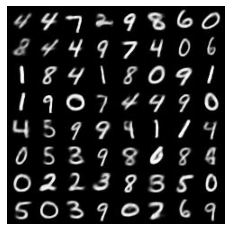

In [15]:
model = model_pipeline(config)
# wandb.agent(sweep_id, model_pipeline, project="VAE-MNIST-Pytorch", count=10)